# General Preparations

In [2]:
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP')

#Import libraries, MDS from SKlearn, and all the custom files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from Pipeline.functions import *


#Data
from aeon.datasets import load_gunpoint
from aeon.datasets import load_basic_motions


#Functions
from QGAP.qgap import QGAP
from Redcomets.Redcomets import REDCOMETS
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
from RDST.rdst import RDST_GAP

In [3]:
# Load Data
XTRAIN, YTRAIN = load_gunpoint(split="TRAIN")
XTEST, YTEST = load_gunpoint(split="TEST")

# XTRAIN, YTRAIN = load_basic_motions(split="TRAIN")
# XTEST, YTEST = load_basic_motions(split="TEST")

#Generate random static variables to test algorithm
XSTATIC = np.random.rand(XTRAIN.shape[0], 45)
XSTATIC_TEST = np.random.rand(XTEST.shape[0], 45)


In [4]:
#Quant
qgap = QGAP(matrix_type="dense")
quant_prox = data_to_proximities(qgap, XTRAIN, YTRAIN, XTEST, XSTATIC,XSTATIC_TEST)

#Redcomets
redcomets = REDCOMETS(variant = 3, static = XSTATIC)
redcomets_prox = data_to_proximities(redcomets, XTRAIN, YTRAIN, XTEST, None , None)

# Rocket
rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512) # Rocket Kwargs
rocket_prox = data_to_proximities(rf_rocket, XTRAIN, YTRAIN, XTEST, XSTATIC , XSTATIC_TEST)

# RDST
rdst = RDST_GAP(save_transformed_data = True)
rdst_prox = data_to_proximities(rdst, XTRAIN, YTRAIN, None, XSTATIC , None)


In [5]:
type(rocket_prox), type(rdst_prox), type(quant_prox), type(redcomets_prox)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [6]:
sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')
from PFGAP.PyPFGAP import PyPFGAP
pf = PyPFGAP()
pf_prox = data_to_proximities(pf, XTRAIN, YTRAIN, None, None, None)

reading file [train]:finished in 0:0:0.020
reading file [test]:finished in 0:0:0.009
Running on configurations...
Dataset: train, Training Data : 50x150 , Testing Data: 50x150, Train #Classes: 2, Test #Classes: 2
Repeats: 1 , Trees: 18 , Candidates per Split(r): 5
Output Dir: output, Export: 1, Verbosity: 1
Select DM per node: true , Shuffle Data: false, JVM WarmUp: false
----------------------------------------------------------------------------------------------------

-----------------Repetition No: 1 (train)   -----------------
Using: 4 MB, Free: 20 MB, Allocated Pool: 24 MB, Max Available: 1024 MB
core.ProximityForestResult@4f3f5b24
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.
Using: 48 MB, Free: 32 MB, Allocated Pool: 80 MB, Max Available: 1024 MB
*
Computing Forest Proximities...
Done Computing Forest Proximities. Computation time: 16.0ms
Training Time: 1671.975869ms (0:0:1.671)
Prediction Time: 275.762219ms (0:0:0.275)
Correct(TP+TN): 50 vs Incorrect(FP+FN): 0
Accuracy: 1.0
Er

# Building MDS Veiwpoints

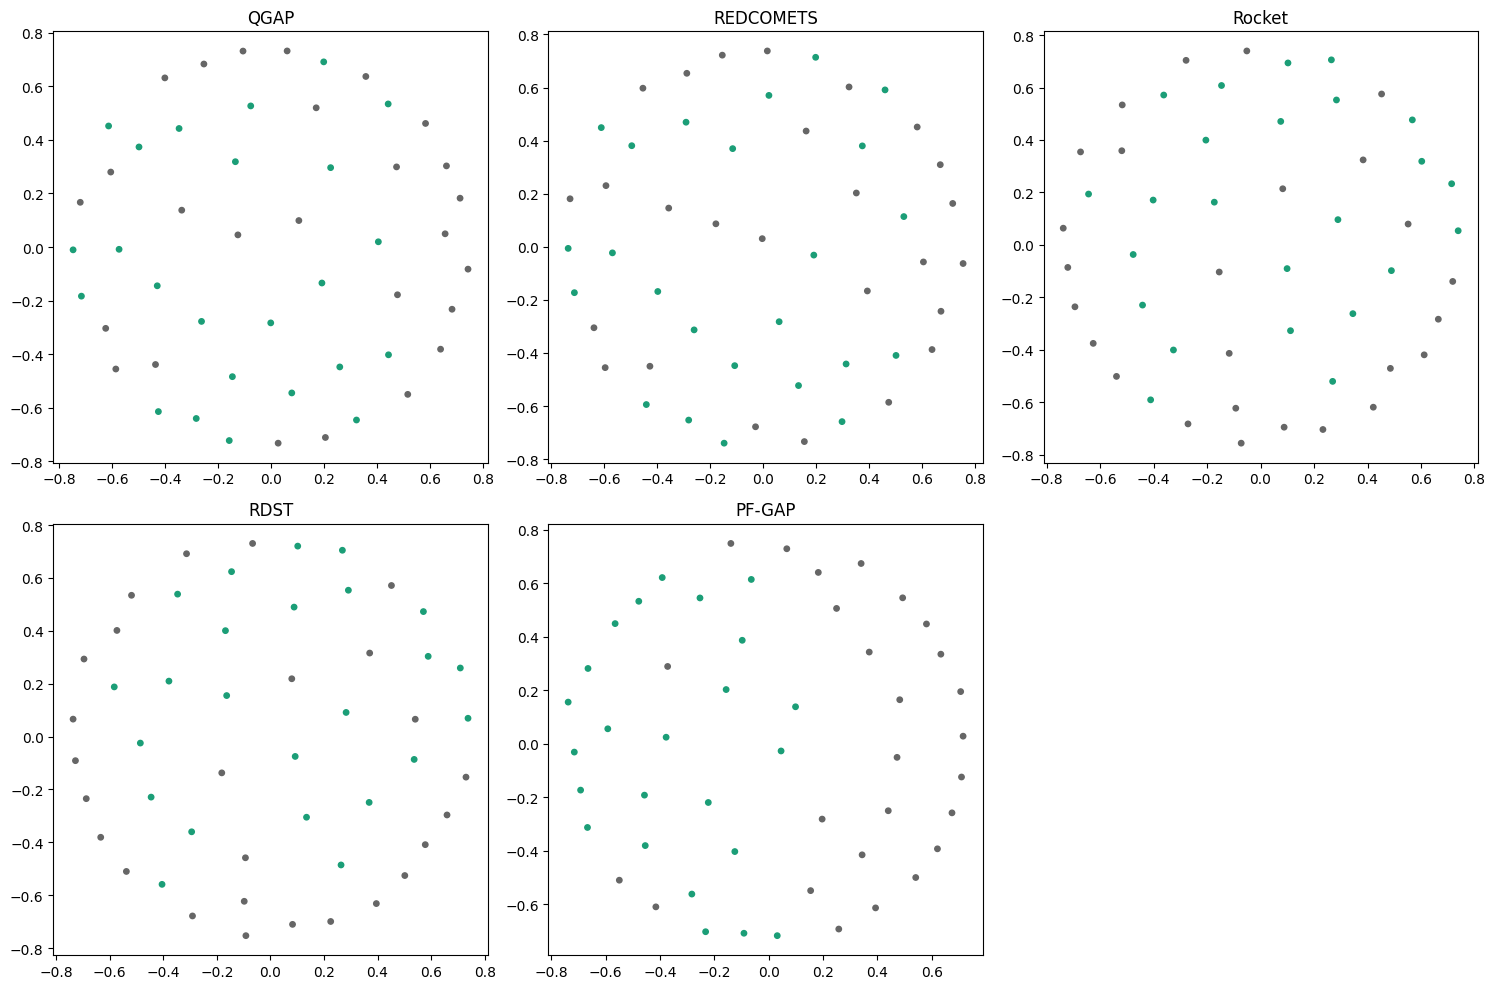

In [7]:
# Initialize MDS
def build_mds(prox):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    symetric = (prox + prox.T) / 2
    mds_prox = mds.fit_transform(1- symetric)
    return mds_prox

# Build MDS for each method
mds_quant = build_mds(quant_prox)
mds_redcomets = build_mds( redcomets_prox)
mds_rocket = build_mds(rocket_prox)
mds_rdst = build_mds(rdst_prox)
mds_pf = build_mds(pf_prox)

# Plot the results
colors = YTRAIN.astype(int)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.scatter(mds_quant[:, 0], mds_quant[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('QGAP')
plt.subplot(2, 3, 2)
plt.scatter(mds_redcomets[:, 0], mds_redcomets[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('REDCOMETS')
plt.subplot(2, 3, 3)
plt.scatter(mds_rocket[:, 0], mds_rocket[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('Rocket')
plt.subplot(2, 3, 4)
plt.scatter(mds_rdst[:, 0], mds_rdst[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('RDST')
plt.subplot(2, 3, 5)
plt.scatter(mds_pf[:, 0], mds_pf[:, 1], c=colors, cmap='Dark2', marker='o', s=15)
plt.title('PF-GAP')
plt.tight_layout()


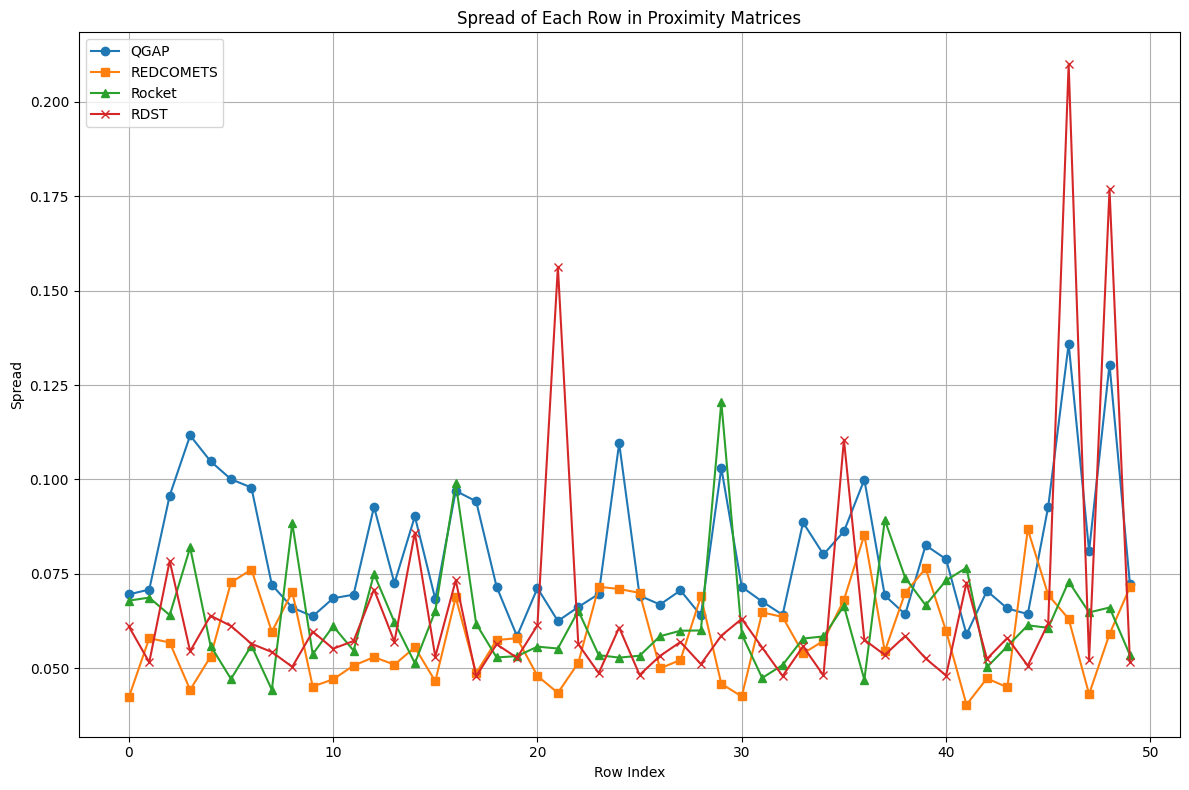

In [8]:
# Function to calculate the spread of each row
def calculate_spread(prox):
    return np.ptp(prox, axis=1) 

# Plot the spread as a line chart
plt.figure(figsize=(12, 8))
plt.plot(calculate_spread(quant_prox), label='QGAP', linestyle='-', marker='o')
plt.plot(calculate_spread(redcomets_prox), label='REDCOMETS', linestyle='-', marker='s')
plt.plot(calculate_spread(rocket_prox), label='Rocket', linestyle='-', marker='^')
plt.plot(calculate_spread(rdst_prox), label='RDST', linestyle='-', marker='x')
plt.xlabel('Row Index')
plt.ylabel('Spread')
plt.title('Spread of Each Row in Proximity Matrices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

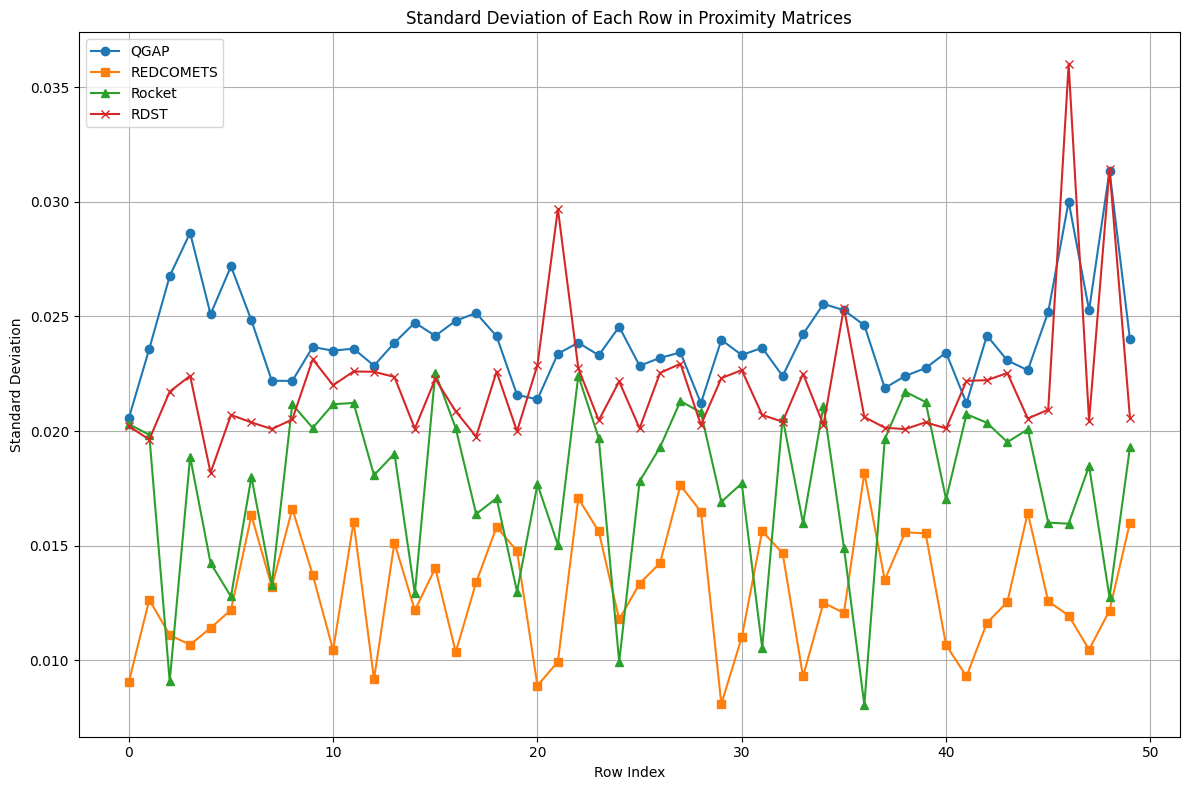

In [9]:
# Function to calculate the spread of each row
def calculate_std(prox):
    return np.std(prox, axis=1)  # Peak-to-peak (max - min) for each row

# Plot the spread as a line chart
plt.figure(figsize=(12, 8))
plt.plot(calculate_std(quant_prox), label='QGAP', linestyle='-', marker='o')
plt.plot(calculate_std(redcomets_prox), label='REDCOMETS', linestyle='-', marker='s')
plt.plot(calculate_std(rocket_prox), label='Rocket', linestyle='-', marker='^')
plt.plot(calculate_std(rdst_prox), label='RDST', linestyle='-', marker='x')
plt.xlabel('Row Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Each Row in Proximity Matrices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

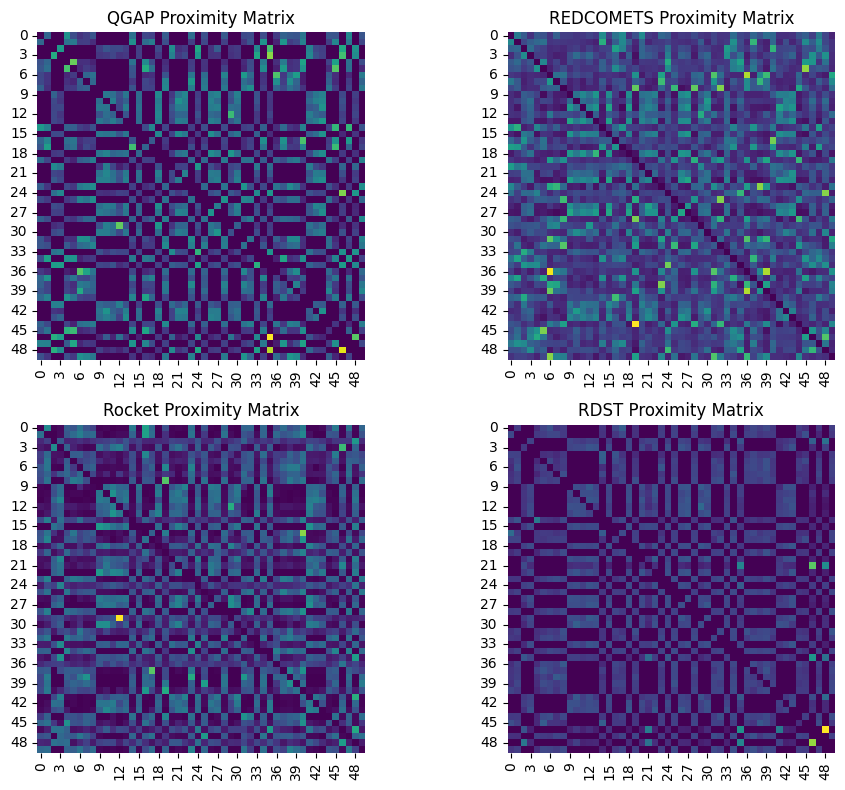

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmaps_in_grid(matrices, titles):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    for ax, matrix, title in zip(axes.flat, matrices, titles):
        sns.heatmap(matrix, cmap='viridis', square=True, ax=ax, cbar=False)
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
titles = ["QGAP Proximity Matrix", "REDCOMETS Proximity Matrix", "Rocket Proximity Matrix", "RDST Proximity Matrix"]

plot_heatmaps_in_grid(matrices, titles)

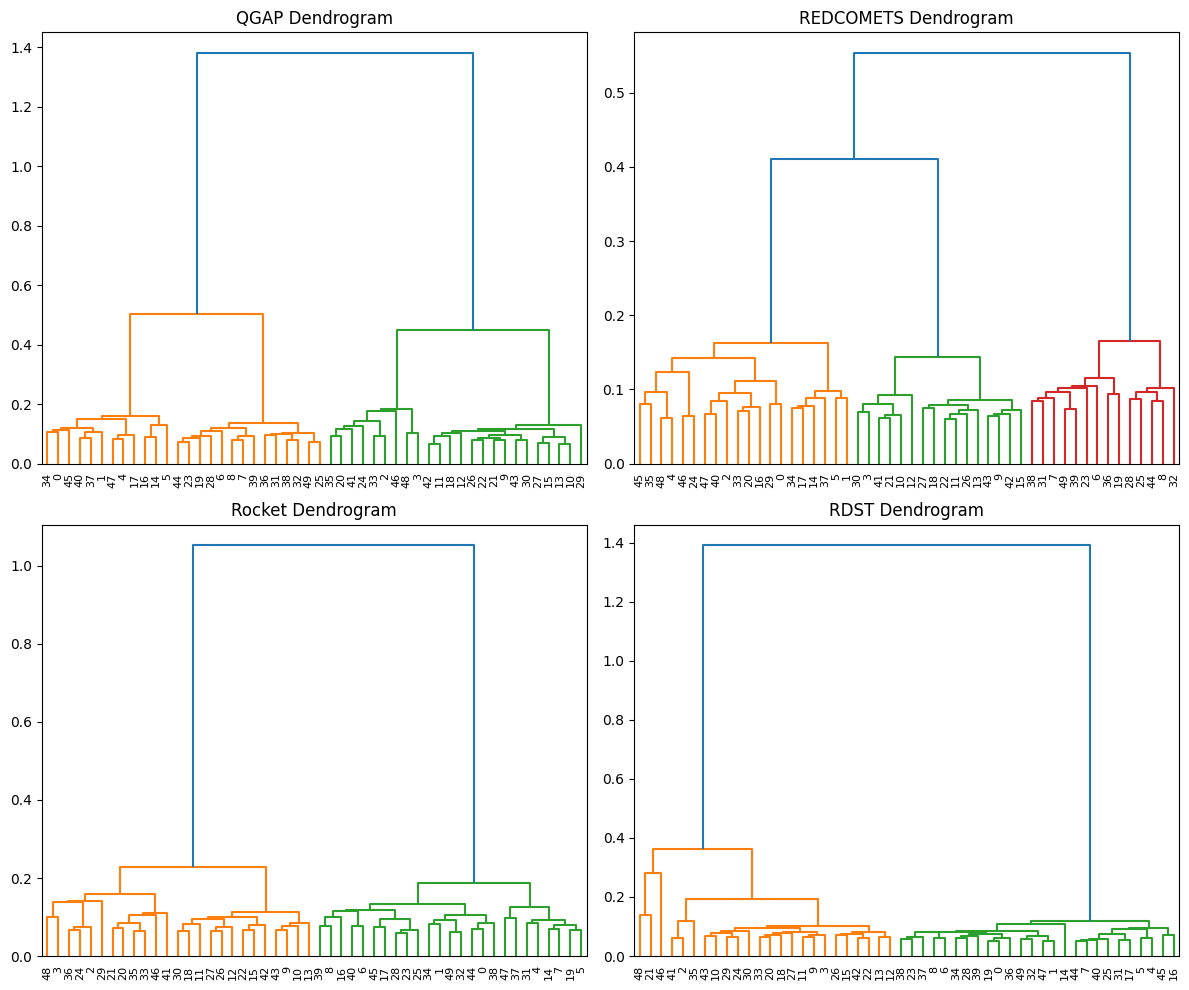

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrograms_in_grid(matrices, titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, matrix, title in zip(axes.flat, matrices, titles):
        linked = linkage(matrix, method='ward')
        dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, ax=ax)
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
titles = ["QGAP Dendrogram", "REDCOMETS Dendrogram", "Rocket Dendrogram", "RDST Dendrogram"]

plot_dendrograms_in_grid(matrices, titles)

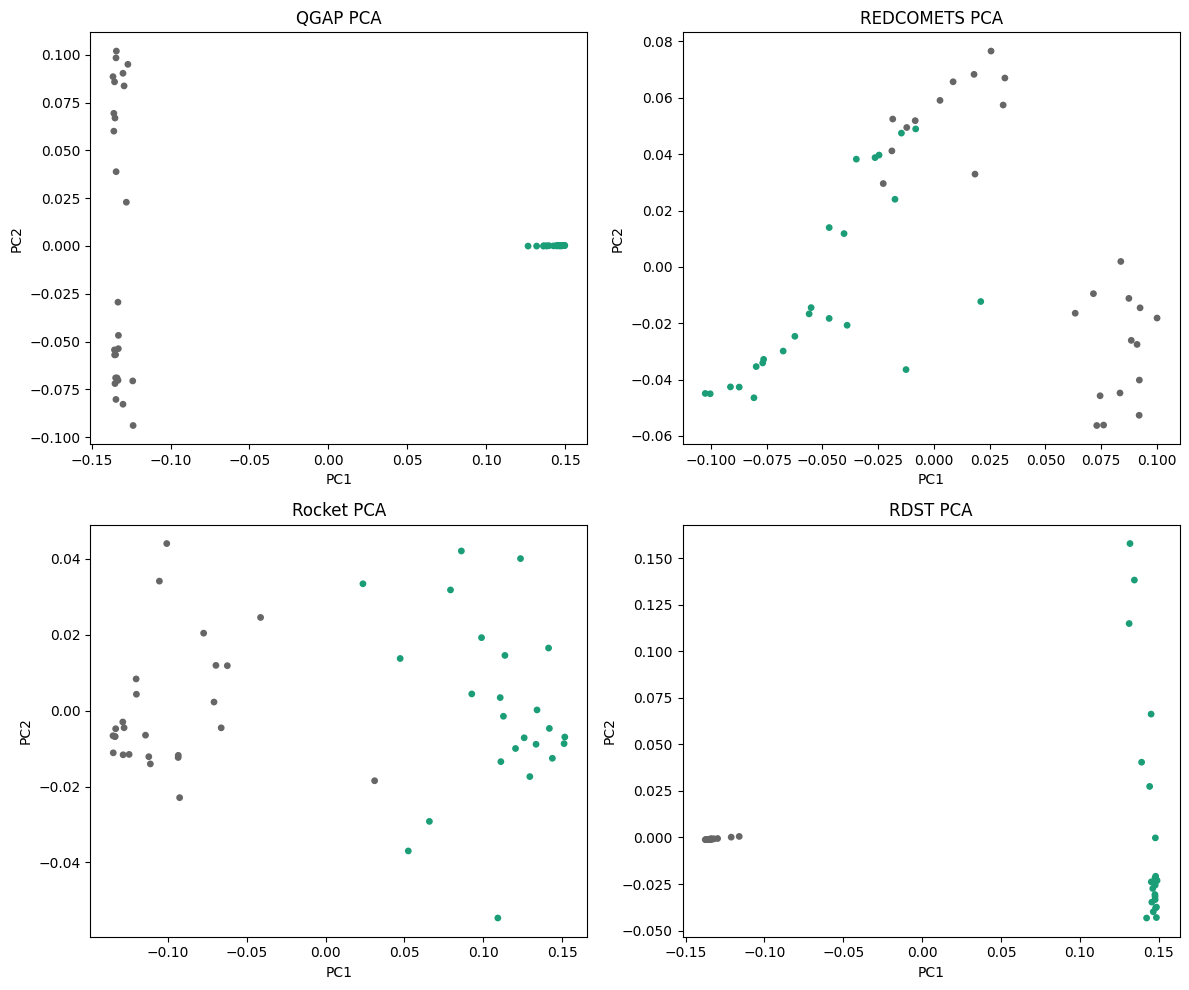

In [12]:
from sklearn.decomposition import PCA

def plot_pca_in_grid(matrices, titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, matrix, title in zip(axes.flat, matrices, titles):
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(matrix)
        ax.scatter(reduced[:, 0], reduced[:, 1], c=YTRAIN.astype(int), cmap='Dark2', s=15)
        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    plt.tight_layout()
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
titles = ["QGAP PCA", "REDCOMETS PCA", "Rocket PCA", "RDST PCA"]

plot_pca_in_grid(matrices, titles)

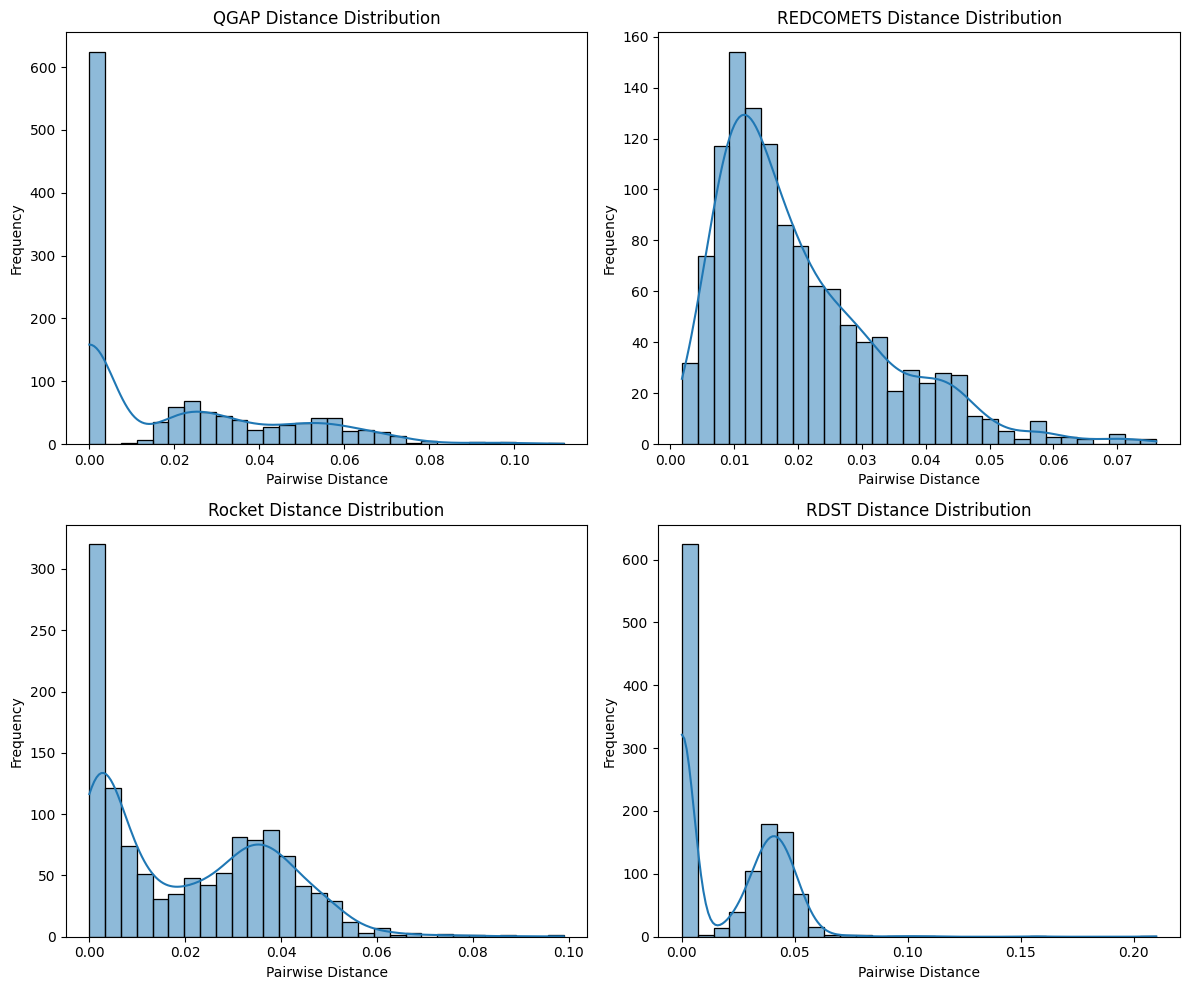

In [13]:
def plot_distance_distributions_in_grid(matrices, titles): # Look at distributions betwen classes. 
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, matrix, title in zip(axes.flat, matrices, titles):
        distances = matrix[np.triu_indices_from(matrix, k=1)]
        sns.histplot(distances, kde=True, bins=30, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Pairwise Distance")
        ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
titles = ["QGAP Distance Distribution", "REDCOMETS Distance Distribution", "Rocket Distance Distribution", "RDST Distance Distribution"]

plot_distance_distributions_in_grid(matrices, titles)

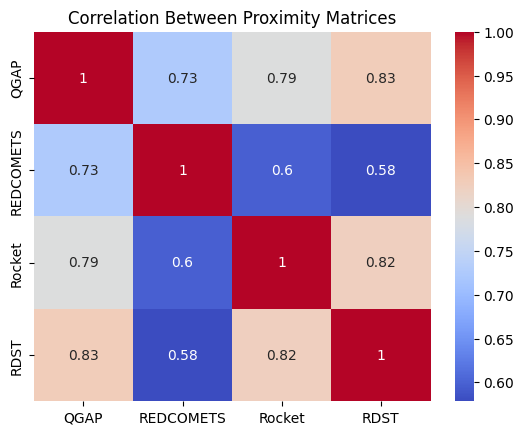

In [14]:
def plot_correlation_matrix(matrices, labels):
    corr_matrix = np.corrcoef([m.flatten() for m in matrices])
    sns.heatmap(corr_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='coolwarm')
    plt.title("Correlation Between Proximity Matrices")
    plt.show()

matrices = [quant_prox, redcomets_prox, rocket_prox, rdst_prox]
labels = ["QGAP", "REDCOMETS", "Rocket", "RDST"]
plot_correlation_matrix(matrices, labels)

In [15]:
# Import pandas for table display
import pandas as pd

# Define a function to calculate statistics
def calculate_statistics(data):
    return {
        "Mean": round(np.mean(data), 3),
        "Std Dev": round(np.std(data), 3)
    }

# Calculate statistics for each proximity
statistics = {
    "MDS - QGAP": calculate_statistics(mds_quant),
    "MDS - REDCOMETS": calculate_statistics(mds_redcomets),
    "MDS - Rocket": calculate_statistics(mds_rocket),
    "MDS - RDST": calculate_statistics(mds_rdst),
    "Prox - QGAP": calculate_statistics(quant_prox),
    "Prox - REDCOMETS": calculate_statistics( redcomets_prox),
    "Prox - Rocket": calculate_statistics(rocket_prox),
    "Prox - RDST": calculate_statistics(rdst_prox),
}

# Convert statistics to a pandas DataFrame
statistics_df = pd.DataFrame.from_dict(statistics, orient="index")
statistics_df.index.name = "Proximity Type"
statistics_df.reset_index(inplace=True)

statistics_df


,Proximity Type,Mean,Std Dev
0,MDS - QGAP,0.00,0.444
1,MDS - REDCOMETS,-0.00,0.444
2,MDS - Rocket,-0.00,0.444
3,MDS - RDST,-0.00,0.444
4,Prox - QGAP,0.02,0.024
5,Prox - REDCOMETS,0.02,0.013
6,Prox - Rocket,0.02,0.018
7,Prox - RDST,0.02,0.022


In [16]:
# Initialize KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=3) #metric = "precomputed"

# Prepare a dictionary to store results
knn_results = {}

# Define a function to train and evaluate KNN
def evaluate_knn(X_train, y_train, label):
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    knn_results[label] = accuracy

# Evaluate KNN on each MDS output
evaluate_knn(mds_quant, YTRAIN.astype(int), "MDS QGAP")
evaluate_knn(mds_redcomets, YTRAIN.astype(int), "MDS REDCOMETS")
evaluate_knn(mds_rocket, YTRAIN.astype(int), "MDS Rocket")
evaluate_knn(mds_rdst, YTRAIN.astype(int), "MDS RDST")

evaluate_knn(1- quant_prox, YTRAIN.astype(int), "QGAP")
evaluate_knn(1 -redcomets_prox, YTRAIN.astype(int), "REDCOMETS")
evaluate_knn(1- rocket_prox, YTRAIN.astype(int), "Rocket")
evaluate_knn(1- rdst_prox, YTRAIN.astype(int), "RDST")

# Convert results to a pandas DataFrame for display
results_df = pd.DataFrame(list(knn_results.items()), columns=["Model", "Accuracy"])
results_df

,Model,Accuracy
0,MDS QGAP,0.90
1,MDS REDCOMETS,0.76
2,MDS Rocket,0.74
3,MDS RDST,0.72
4,QGAP,1.00
5,REDCOMETS,0.98
6,Rocket,0.98
7,RDST,1.00


In [17]:
np.mean(rf_rocket.predict(XTRAIN, XSTATIC) == YTRAIN)

np.float64(1.0)

In [18]:
np.mean(rf_rocket.predict(XTEST, XSTATIC_TEST) == YTEST)

np.float64(0.9933333333333333)

In [19]:
rf_rocket.rf_gap.oob_score_

0.98